# Vision Transformer

- Dogs vs Cats Dataset : [https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data)

```
data
    - train
    - test
```

- Reference : [https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit_pytorch.py](https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit_pytorch.py)

- Window

In [38]:
import os
import glob
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

from einops import rearrange, repeat
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [39]:
seed = 1211

In [40]:
train_path = 'data/train'
test_path = 'data/test'

In [41]:
train_paths = glob.glob(os.path.join(train_path,'*.jpg'))
test_paths = glob.glob(os.path.join(test_path, '*.jpg'))

In [42]:
labels = np.array([path.split('\\')[-1].split('.')[0] for path in train_paths])

In [43]:
labels[labels == 'dog'] = 1
labels[labels == 'cat'] = 0

In [44]:
labels = labels.astype(np.int64)

In [45]:
train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths, 
                                                                        labels,
                                                                        test_size=0.2,
                                                                        stratify=labels,
                                                                        random_state=seed)

In [46]:
print(f"Train Data: {len(train_paths)}")
print(f"Validation Data: {len(valid_paths)}")
print(f"Test Data: {len(test_paths)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


In [47]:
Counter(train_labels)

Counter({1: 10000, 0: 10000})

In [48]:
Counter(valid_labels)

Counter({0: 2500, 1: 2500})

In [49]:
class CatsDogsTrainDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx])
        
        if self.transform is not None:
            img = self.transform(img)
              
        label = self.labels[idx]

        return img, label
    
    
class CatsDogsTestDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx])
        
        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [50]:
image_size = 224
batch_size = 32
device = 'cuda'

In [51]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

valid_transforms = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ]
)

In [52]:
train_dataset = CatsDogsTrainDataset(train_paths, train_labels, transform=train_transforms)
valid_dataset = CatsDogsTrainDataset(valid_paths, train_labels, transform=test_transforms)
test_dataset = CatsDogsTestDataset(test_paths, transform=test_transforms)

In [53]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [54]:
sample_data, sample_label = next(train_loader.__iter__())
print(sample_data.shape)

torch.Size([32, 3, 224, 224])


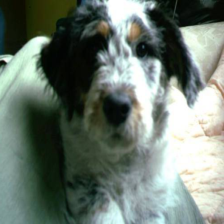

In [55]:
transforms.ToPILImage()(sample_data[0])

torch.Size([32, 7, 7, 3, 32, 32])


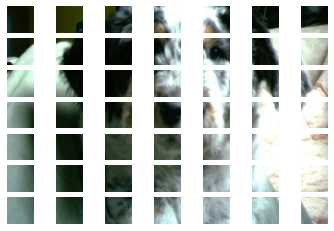

In [56]:
p = 32
N = image_size // p

rearrange_data = rearrange(sample_data, 'b c (h p1) (w p2) -> b h w c p1 p2', p1 = p, p2 = p)
print(rearrange_data.shape)

fig, ax = plt.subplots(N, N)

for i in range(0, N):
    for j in range(0, N):
        patch = rearrange_data[0][i][j] 
        
        img = transforms.ToPILImage()(patch)
        ax[i][j].imshow(img)
        ax[i][j].axis('off')

In [59]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.w1 = nn.Linear(d_model, d_ff)
        self.gelu = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.w2 = nn.Linear(d_ff, d_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        x = self.w1(x)
        x = self.gelu(x)
        x = self.dropout1(x)
        x = self.w2(x)
        x = self.dropout2(x)
        
        return x
        
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout):
        super().__init__()
        assert d_model % n_heads == 0
        
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.d_model = d_model
        self.attention = None
        
        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)
        
        self.wo = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = d_model ** -0.5
        
    def forward(self, query, key, value, mask = None):
        b = query.shape[0]

        Q = self.wq(query)
        K = self.wk(key)
        V = self.wv(value)
    
        Q = Q.view(b, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(b, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(b, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) * self.scale

        if mask is not None:
            energy = energy.masked_fill(mask==0, -1e10)
            
        self.attention = torch.softmax(energy, dim=-1)
        x = torch.matmul(self.dropout(self.attention), V)
        
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(b, -1, self.d_model)
        x = self.wo(x)
        
        return x
        
class Transformer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, N, dropout=0.1):
        super().__init__()
        
        self.encoders = nn.ModuleList([Encoder(d_model, n_heads, d_ff, dropout) for _ in range(N)]) 
        
    def forward(self, x, mask=None):
        for encoder in self.encoders:
            x = encoder(x, mask)
        
        return x
        
class Encoder(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super().__init__()
        
        self.attention_prenorm = nn.LayerNorm(d_model)
        self.attention = MultiHeadAttention(d_model, n_heads, dropout)
        
        self.feedforward_prenorm = nn.LayerNorm(d_model)
        self.feedforward = FeedForward(d_model, d_ff, dropout)
        
    def forward(self, x, mask=None):
        y = self.attention_prenorm(x)
        y = self.attention(y, y, y, mask)
        x = x + y
        
        y = self.feedforward_prenorm(x)
        y = self.feedforward(y)
        x = x + y
        
        return x
        
        
class ViT(nn.Module):
    def __init__(self, 
                 image_size, 
                 patch_size, 
                 num_classes, 
                 d_model,
                 N, 
                 n_heads, 
                 d_ff, 
                 pool='cls', 
                 channels=3,
                 dropout=0.,
                 emb_dropout=0.):
        super().__init__()
        
        n_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2
        
        self.patch_size = patch_size
        
        self.pos_embedding = nn.Parameter(torch.randn(1, n_patches + 1, d_model))
        self.patch_embedding = nn.Linear(patch_dim, d_model)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.dropout = nn.Dropout(emb_dropout)
        
        self.transformer = Transformer(d_model, n_heads, d_ff, N, dropout)
        
        self.pool = pool
        self.to_latent = nn.Identity()
        
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, num_classes)
        )
        
    def forward(self, x, mask=None):
        p = self.patch_size
        
        x = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = p, p2 = p)
        x = self.patch_embedding(x)
        
        # b x n_patches x patch_dim
        b, n, _ = x.shape 
        
        # 1 x 1 x d_model -> b x 1 x d_model
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        
        # b x n_patches+1 x patch_dim
        x = torch.cat((cls_tokens, x), dim=1)
        
        # b x n_patches+1 x patch_dim
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)
        
        x = self.transformer(x, mask)
        
        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]
        
        x = self.to_latent(x)
        return self.mlp_head(x)

In [60]:
lr = 0.001
epochs = 20
gamma = 0.7
device = 'cuda'

In [61]:
v = ViT(
    image_size = 224,
    patch_size = 32,
    num_classes = 2,
    d_model = 256,
    N = 3,
    n_heads = 8,
    d_ff = 512,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

# img = torch.randn(1, 3, 256, 256)
# mask = torch.ones(1, 8, 8).bool() # optional mask, designating which patch to attend to

# preds = v(img, mask = mask) # (1, 1000)

In [62]:
# loss function
criterion = nn.CrossEntropyLoss().to(device)
# optimizer
optimizer = optim.Adam(v.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [63]:
for e in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = v(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = v(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {e+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.6963 - acc: 0.5378 - val_loss : 0.7172 - val_acc: 0.4974



  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6759 - acc: 0.5751 - val_loss : 0.7312 - val_acc: 0.5016



  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.6592 - acc: 0.5966 - val_loss : 0.7433 - val_acc: 0.5002



  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.6497 - acc: 0.6068 - val_loss : 0.7493 - val_acc: 0.5064



  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.6438 - acc: 0.6159 - val_loss : 0.7628 - val_acc: 0.5028



  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6369 - acc: 0.6210 - val_loss : 0.7791 - val_acc: 0.5137



  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6364 - acc: 0.6221 - val_loss : 0.7654 - val_acc: 0.4960



  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6327 - acc: 0.6265 - val_loss : 0.7970 - val_acc: 0.5012



  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6266 - acc: 0.6389 - val_loss : 0.7740 - val_acc: 0.5006



  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6249 - acc: 0.6380 - val_loss : 0.7920 - val_acc: 0.5012



  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.6180 - acc: 0.6454 - val_loss : 0.8441 - val_acc: 0.4990



  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.6154 - acc: 0.6511 - val_loss : 0.7914 - val_acc: 0.4998



  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.6129 - acc: 0.6522 - val_loss : 0.7734 - val_acc: 0.5155



  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.6077 - acc: 0.6576 - val_loss : 0.7425 - val_acc: 0.5098



  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.6049 - acc: 0.6594 - val_loss : 0.7865 - val_acc: 0.5072



  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.6003 - acc: 0.6681 - val_loss : 0.8053 - val_acc: 0.5131



  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.5991 - acc: 0.6707 - val_loss : 0.7883 - val_acc: 0.5107



  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.5910 - acc: 0.6765 - val_loss : 0.8168 - val_acc: 0.5109



  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.5874 - acc: 0.6816 - val_loss : 0.7978 - val_acc: 0.5153



100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [02:20<00:00,  4.45it/s]


Epoch : 20 - loss : 0.5842 - acc: 0.6863 - val_loss : 0.8418 - val_acc: 0.5125

